In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import gc

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

torch.manual_seed(19)

In [140]:
class MNIST_dataset(Dataset):
    
    def __init__(self, df, lcol, height, width, n_classes=10, transform=transforms.ToTensor(), oh_enc=True):
        self.df = df.drop(columns=lcol).values.reshape(-1, height, width, 1)
        temp = torch.from_numpy(df[lcol].values)
        if oh_enc:
            self.labels = torch.zeros((self.df.shape[0], n_classes))
            self.labels.scatter_(1, temp.view(-1, 1), 1).type('torch.LongTensor')
        else:
            self.labels = temp.type('torch.LongTensor')
        self.transform = transform
        
    def __len__(self):
        return self.df.shape[0]
        
    def __getitem__(self, idx):
        label = self.labels[idx]
        if self.transform:
            item = self.transform(self.df[idx]).type('torch.FloatTensor')
        return item, label
    
    def train_test_split(self, test_size):
        test_length = int(test_size * len(self))
        train_length = len(self) - test_length
        return random_split(self, [train_length, test_length])
    
    def draw(self, idx):
        lab = torch.argmax(self.labels[idx])
        print(lab.item())
        plt.imshow(self.df[idx].reshape(self.df[idx].shape[1], -1))
        
class Flatten(nn.Module):
    
    def forward(self, x):
        _, C, H, W = x.shape
        return x.view(-1, C*H*W)

# MNIST data set:

In [141]:
mnist = pd.read_csv('Data/mnist.csv')
mnist.head()

,label,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Creating torch data set, row vectors will be converted to **(height x width)** matrices:

In [142]:
data = MNIST_dataset(mnist, 'label', height=28, width=28, oh_enc=False)

6


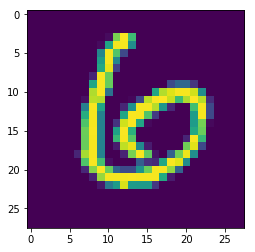

In [150]:
data.draw(11)

Splitting the data:

In [152]:
train, test = data.train_test_split(test_size=0.2)

Specifying netwrork's architecture:

In [269]:
class CNN_MNIST(nn.Module):
    
    def __init__(self, activation):
        super().__init__()
        self.activation = activation()
        self.conv = nn.ModuleList([nn.Conv2d(1, 8, 3),
                     nn.Conv2d(8, 8, 3),
                     nn.Conv2d(8, 8, 3)])
        self.pool = nn.MaxPool2d(2, 2)
        self.flat = Flatten()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, 10)
        
    def forward(self, x):
        for layer in self.conv:
            x = self.pool(self.activation(layer(x)))
        x = self.flat(x)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.out(x)
        return x
        
    def fit(self, dataset, loss, opt, n_epochs, batch_size):
        
        loss = loss
        d_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
        for i in tqdm_notebook(range(n_epochs)):
            j = 0
            rloss = 0
            for X_batch, y_batch in d_loader: 
                opt.zero_grad()
                
                out = self(X_batch)
                
                loss_val = loss(out, y_batch)
                
                rloss += loss_val.item()
                j += 1
                
                loss_val.backward()
                
                opt.step()
            print(f'Epoch #{i}: Mean LOSS = {rloss/j}')
                
    def assess_accuracy(self, dataset):
        
        self.eval()
        
        corr = torch.zeros(10)
        total = torch.zeros(10)
        for X, y in DataLoader(dataset, batch_size=1024):
            
            out = torch.argmax(self(X), 1)
            
            res = out == y
            for i, lab in enumerate(y):
                corr[lab] += res[i]
                total[lab] += 1
        
        o_string = ''
        acc = corr.div(total)
        for i in range(10):
            o_string += f'Accuracy of {i}: {round(acc[i].item(), 3)}\n'
        print(o_string)
        print(f'Total accuracy = {round(torch.mean(acc).item(), 3)}')

### Sigmoid activation function:

In [270]:
SIGMOID_MNIST = CNN_MNIST(nn.Sigmoid)

optimizer = torch.optim.Adam(SIGMOID_MNIST.parameters(), weight_decay=0.01)
loss = nn.CrossEntropyLoss(reduction='sum')

In [271]:
SIGMOID_MNIST.fit(train, loss, optimizer, 200, 128)

Epoch #0: Mean LOSS = 292.68028743683345
Epoch #1: Mean LOSS = 292.53336249457465
Epoch #2: Mean LOSS = 292.42884923541357
Epoch #3: Mean LOSS = 292.48744298541357
Epoch #4: Mean LOSS = 292.3601551358662
Epoch #5: Mean LOSS = 291.995109194801
Epoch #6: Mean LOSS = 288.1599372984871
Epoch #7: Mean LOSS = 261.9282506306966
Epoch #8: Mean LOSS = 232.5427012367854
Epoch #9: Mean LOSS = 219.9820786733476
Epoch #10: Mean LOSS = 211.43647862994482
Epoch #11: Mean LOSS = 203.92601134285096
Epoch #12: Mean LOSS = 198.57206459650916
Epoch #13: Mean LOSS = 193.91632237510075
Epoch #14: Mean LOSS = 189.8921340457977
Epoch #15: Mean LOSS = 186.30078706287202
Epoch #16: Mean LOSS = 183.47843690902468
Epoch #17: Mean LOSS = 180.82798936631946
Epoch #18: Mean LOSS = 178.08445703415643
Epoch #19: Mean LOSS = 175.6264185829768
Epoch #20: Mean LOSS = 173.43406398712642
Epoch #21: Mean LOSS = 171.7160873413086
Epoch #22: Mean LOSS = 170.16642458476719
Epoch #23: Mean LOSS = 167.52740623837425
Epoch #24: M

Epoch #196: Mean LOSS = 27.117486015198722
Epoch #197: Mean LOSS = 26.441777093069895
Epoch #198: Mean LOSS = 26.50876591697572
Epoch #199: Mean LOSS = 26.293163950481112


In [273]:
SIGMOID_MNIST.assess_accuracy(test)

Accuracy of 0: 0.939
Accuracy of 1: 0.96
Accuracy of 2: 0.905
Accuracy of 3: 0.907
Accuracy of 4: 0.891
Accuracy of 5: 0.855
Accuracy of 6: 0.934
Accuracy of 7: 0.829
Accuracy of 8: 0.828
Accuracy of 9: 0.909

Total accuracy = 0.896


### Tanh activation:

In [279]:
TANH_MNIST = CNN_MNIST(nn.Tanh)

optimizer = torch.optim.Adam(TANH_MNIST.parameters(), weight_decay=0.01)
loss = nn.CrossEntropyLoss(reduction='sum')

In [280]:
TANH_MNIST.fit(train, loss, optimizer, 100, 128)

Epoch #0: Mean LOSS = 254.2985359070793
Epoch #1: Mean LOSS = 144.12471232338558
Epoch #2: Mean LOSS = 91.4571410285102
Epoch #3: Mean LOSS = 68.87169084094819
Epoch #4: Mean LOSS = 56.37097270905026
Epoch #5: Mean LOSS = 48.336078341045074
Epoch #6: Mean LOSS = 43.78484898521786
Epoch #7: Mean LOSS = 38.92613338288807
Epoch #8: Mean LOSS = 35.72431500752767
Epoch #9: Mean LOSS = 33.30994627210829
Epoch #10: Mean LOSS = 31.93095004369342
Epoch #11: Mean LOSS = 29.183512188139417
Epoch #12: Mean LOSS = 27.77998103792705
Epoch #13: Mean LOSS = 26.481946990603493
Epoch #14: Mean LOSS = 26.06136617206392
Epoch #15: Mean LOSS = 24.626864039708696
Epoch #16: Mean LOSS = 23.117916379656112
Epoch #17: Mean LOSS = 22.625355508592392
Epoch #18: Mean LOSS = 21.968732879275368
Epoch #19: Mean LOSS = 21.001605321490576
Epoch #20: Mean LOSS = 20.10993828849187
Epoch #21: Mean LOSS = 19.623528283739848
Epoch #22: Mean LOSS = 19.110522958967422
Epoch #23: Mean LOSS = 18.61676047340272
Epoch #24: Mean 

Tanh converges faster than sigmoid.

In [281]:
TANH_MNIST.assess_accuracy(test)

Accuracy of 0: 0.949
Accuracy of 1: 0.96
Accuracy of 2: 0.905
Accuracy of 3: 0.912
Accuracy of 4: 0.87
Accuracy of 5: 0.907
Accuracy of 6: 0.929
Accuracy of 7: 0.912
Accuracy of 8: 0.874
Accuracy of 9: 0.919

Total accuracy = 0.914


### ReLU activation:

In [283]:
RELU_MNIST = CNN_MNIST(nn.ReLU)

optimizer = torch.optim.Adam(RELU_MNIST.parameters(), weight_decay=0.01)
loss = nn.CrossEntropyLoss(reduction='sum')

In [284]:
RELU_MNIST.fit(train, loss, optimizer, 100, 128)

Epoch #0: Mean LOSS = 198.74525621202258
Epoch #1: Mean LOSS = 83.47246145823645
Epoch #2: Mean LOSS = 57.52038289630224
Epoch #3: Mean LOSS = 46.29170281546457
Epoch #4: Mean LOSS = 39.55557750520252
Epoch #5: Mean LOSS = 34.88693773178827
Epoch #6: Mean LOSS = 31.183220999581472
Epoch #7: Mean LOSS = 29.069204451545836
Epoch #8: Mean LOSS = 26.750705794682577
Epoch #9: Mean LOSS = 25.641151988317095
Epoch #10: Mean LOSS = 22.410862559363956
Epoch #11: Mean LOSS = 21.596875296698677
Epoch #12: Mean LOSS = 19.774228005182174
Epoch #13: Mean LOSS = 18.322747253236315
Epoch #14: Mean LOSS = 18.412992333608962
Epoch #15: Mean LOSS = 16.603400767795623
Epoch #16: Mean LOSS = 16.77733492472815
Epoch #17: Mean LOSS = 15.148555975111703
Epoch #18: Mean LOSS = 15.178980865175761
Epoch #19: Mean LOSS = 15.866049781678216
Epoch #20: Mean LOSS = 13.678682130480569
Epoch #21: Mean LOSS = 13.031716914404006
Epoch #22: Mean LOSS = 11.902560559530107
Epoch #23: Mean LOSS = 12.194136104886494
Epoch #2

ReLU is the fastest of the three.

In [285]:
RELU_MNIST.assess_accuracy(test)

Accuracy of 0: 0.974
Accuracy of 1: 0.973
Accuracy of 2: 0.965
Accuracy of 3: 0.956
Accuracy of 4: 0.918
Accuracy of 5: 0.912
Accuracy of 6: 0.944
Accuracy of 7: 0.922
Accuracy of 8: 0.874
Accuracy of 9: 0.97

Total accuracy = 0.941


# Letters data set:

In [466]:
import os
from skimage import io

class Letters_dataset(Dataset):
    
    def __init__(self, path, transforms=None):
        self.transforms = transforms
        self.enc = {}
        self.df = {}
        self.labels = []
        j = 0
        for i, folder in enumerate(os.listdir(path)):
            self.enc[i] = folder
            for file in os.listdir(os.path.join(path, folder)):
                self.df[j] = os.path.join(path, folder, file)
                self.labels.append(i)
                j += 1
                #self.df.append([os.path.join(path, folder, file), i])
        #self.df = pd.DataFrame(self.df, columns=['path', 'label'])
        self.labels = torch.LongTensor(self.labels)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        #path, label = self.df.iloc[idx]
        path = self.df[idx.item()]
        label = self.labels[idx.item()]
        image = io.imread(path)
        image = image.reshape((*image.shape, 1))
        if self.transforms:
            image = self.transforms(image)
        return image, label
    
    def train_test_split(self, test_size):
        test_length = int(test_size * len(self))
        train_length = len(self) - test_length
        return random_split(self, [train_length, test_length])
    
    def draw(self, idx):
        #path, label = self.df.iloc[idx]
        path = self.df[idx]
        label = self.labels[idx]
        image = io.imread(path)
        plt.imshow(image)
        plt.title(self.enc[label.item()])
    
    def draw_sample(self, n=4):
        indices = np.random.choice(len(self), size=n, replace=False)
        fig, axarr = plt.subplots(n//2, 2, figsize = [7, 7])
        for i, idx in enumerate(indices):
            #path, label = self.df.iloc[idx]
            
            path = self.df[idx.item()]
            label = self.labels[idx.item()]
            
            image = io.imread(path)
            ax = axarr[i//2, i%2]
            ax.imshow(image)
            ax.set_title(self.enc[label.item()])

In [467]:
letters_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.ToPILImage(),
                                        transforms.RandomRotation(40),
                                        transforms.ToTensor()])
letters = Letters_dataset(data_path, transforms=letters_transforms)

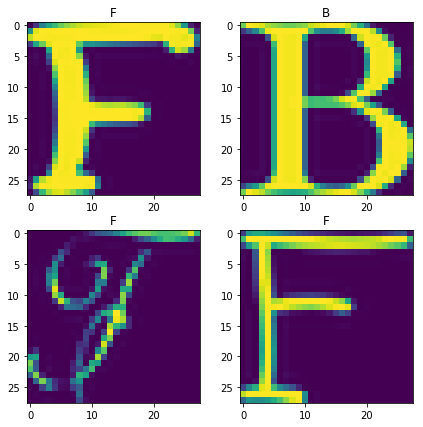

In [468]:
letters.draw_sample()

In [469]:
l_train, l_test = letters.train_test_split(test_size=0.2)

In [488]:
class LETTERS_CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.convolve = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1), 
                                      self.activation,
                                      self.pool,
                                      nn.BatchNorm2d(16),
                                      nn.Dropout2d(p=0.2),
                                      nn.Conv2d(16, 32, 5),
                                      self.activation,
                                      self.pool)
        self.flat = Flatten()
        self.fc1 = nn.Linear(800, 128)
        self.d_out1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.d_out2 = nn.Dropout(p=0.25)
        self.out = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.convolve(x)
        x = self.flat(x)
        #print(x.shape)
        x = self.activation(self.fc1(self.d_out1(x)))
        x = self.activation(self.fc2(self.d_out2(x)))
        x = self.out(x)
        return x
    
    def fit(self, dataset, loss, opt, n_epochs, batch_size):
        self.train()
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        for i in tqdm_notebook(range(n_epochs)):
            rloss = 0
            j = 0
            for X_batch, y_batch in data_loader:
                
                opt.zero_grad()
                
                out = self(X_batch)
                
                loss_val = loss(out, y_batch)
                
                rloss += loss_val.item()
                j+= 1
                
                loss_val.backward()
                
                opt.step()
            print(f'Epoch #{i}: Mean LOSS = {rloss/j}')
            
    
    def assess_accuracy(self, dataset, labels):
        self.eval()
        
        corr = torch.zeros(10)
        total = torch.zeros(10)
        for X, y in DataLoader(dataset, batch_size=1024):
            
            out = torch.argmax(self(X), 1)
            
            res = out == y
            for i, lab in enumerate(y):
                corr[lab] += res[i]
                total[lab] += 1
        
        o_string = ''
        acc = corr.div(total)
        for i in range(10):
            o_string += f'Accuracy of {labels[i]}: {round(acc[i].item(), 3)}\n'
        print(o_string)
        print(f'Total accuracy = {round(torch.mean(acc).item(), 3)}')

### Training:

In [489]:
NET = LETTERS_CNN()

optimizer = torch.optim.Adam(NET.parameters(), weight_decay=0.005)
loss = nn.CrossEntropyLoss(reduction='sum')

In [490]:
NET.fit(l_train, loss, optimizer, 200, 128)

Epoch #0: Mean LOSS = 137.8264233176991
Epoch #1: Mean LOSS = 82.6313179731369
Epoch #2: Mean LOSS = 70.77797585523734
Epoch #3: Mean LOSS = 64.39844090857748
Epoch #4: Mean LOSS = 61.59676790237427
Epoch #5: Mean LOSS = 56.46248682474686
Epoch #6: Mean LOSS = 54.11720935773041
Epoch #7: Mean LOSS = 52.69561835870905
Epoch #8: Mean LOSS = 49.066121889373
Epoch #9: Mean LOSS = 49.64433024091235
Epoch #10: Mean LOSS = 48.4564253758576
Epoch #11: Mean LOSS = 48.55729836528584
Epoch #12: Mean LOSS = 45.662021010608996
Epoch #13: Mean LOSS = 45.9668705705869
Epoch #14: Mean LOSS = 44.45197754391169
Epoch #15: Mean LOSS = 43.71859372268289
Epoch #16: Mean LOSS = 43.46866899425701
Epoch #17: Mean LOSS = 42.821286064083296
Epoch #18: Mean LOSS = 42.49818214723619
Epoch #19: Mean LOSS = 41.1814859277111
Epoch #20: Mean LOSS = 40.932172979338695
Epoch #21: Mean LOSS = 39.98135268486152
Epoch #22: Mean LOSS = 40.6795534491539
Epoch #23: Mean LOSS = 39.899101922067544
Epoch #24: Mean LOSS = 39.886

Epoch #196: Mean LOSS = 25.781280255923836
Epoch #197: Mean LOSS = 26.471170174873482
Epoch #198: Mean LOSS = 25.665268881846284
Epoch #199: Mean LOSS = 25.081053291336964


In [491]:
LETTERS_CNN.assess_accuracy(NET, l_train, letters.enc)

Accuracy of A: 0.981
Accuracy of B: 0.975
Accuracy of C: 0.97
Accuracy of D: 0.977
Accuracy of E: 0.981
Accuracy of F: 0.983
Accuracy of G: 0.967
Accuracy of H: 0.989
Accuracy of I: 0.952
Accuracy of J: 0.971

Total accuracy = 0.975


In [494]:
LETTERS_CNN.assess_accuracy(NET, l_test, letters.enc)

Accuracy of A: 0.96
Accuracy of B: 0.951
Accuracy of C: 0.955
Accuracy of D: 0.951
Accuracy of E: 0.941
Accuracy of F: 0.945
Accuracy of G: 0.944
Accuracy of H: 0.964
Accuracy of I: 0.887
Accuracy of J: 0.947

Total accuracy = 0.945
